<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Project Title: Text Classification Using Longformer-FineTuning</b></h1>



### Tabel of Contents:



* [Import Libraries](#1)

* [Load Dataset](#2)

* [Longformer Model](#4)

* [Evaluation](#3)

* [Predictive for Test](#8)

* [Like this? Upvote and comment! 🌊 End](#6)

**<a id="1"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Import Libraries</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
!pip install datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset, Dataset
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
from huggingface_hub import login
import wandb
wandb.init(mode = "disabled")
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**<a id="2"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Load Dataset</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [3]:
# Load dataset
dataset = load_dataset("jahjinx/IMDb_movie_reviews")
dataset

README.md:   0%|          | 0.00/4.24k [00:00<?, ?B/s]

IMDB_train.csv:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

IMDB_validation.csv:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

IMDB_test.csv:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/36000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 36000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

In [4]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
validation_df = pd.DataFrame(dataset['validation'])
train_df.head()

,text,label
0,"Beautifully photographed and ably acted, gener...",0
1,"Well, where to start describing this celluloid...",0
2,I first caught the movie on its first run on H...,1
3,I love Umberto Lenzi's cop movies -- ROME ARME...,0
4,I generally won't review movies I haven't seen...,0


In [5]:
train_df.shape

(36000, 2)

In [6]:
test_df.head()

,text,label
0,With No Dead Heroes you get stupid lines like ...,0
1,I thought maybe... maybe this could be good. A...,0
2,An elite American military team which of cours...,0
3,Ridiculous horror film about a wealthy man (Jo...,0
4,"Well, if you are one of those Katana's film-nu...",1


In [7]:
validation_df.head()

,text,label
0,I watched this movie based on the comments of ...,0
1,"At the end of the film I just asked myself :""i...",0
2,'War movie' is a Hollywood genre that has been...,1
3,After having seen the movie the first question...,0
4,"The Stepford Children, besides being a very go...",1


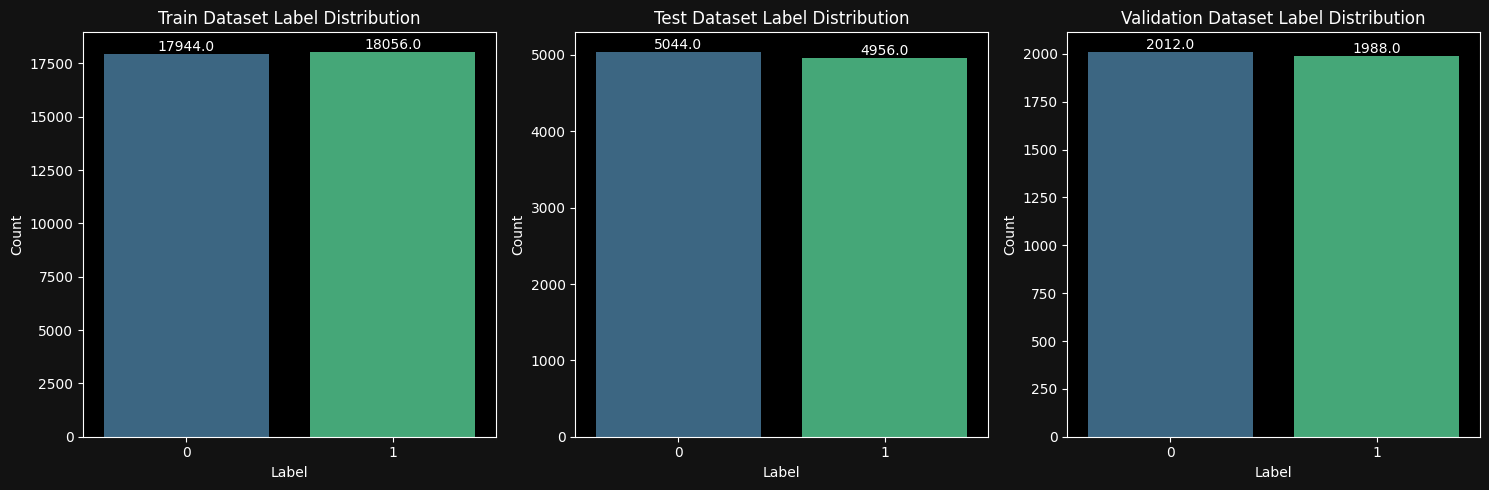

In [8]:
plt.figure(figsize=(15, 5), facecolor='#121212')
plt.style.use('dark_background')
# Create subplots
plt.subplot(1, 3, 1)
sns.countplot(x='label', data=train_df, palette="viridis")
plt.title('Train Dataset Label Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='white', xytext=(0, 5),
                   textcoords='offset points')
plt.subplot(1, 3, 2)
sns.countplot(x='label', data=test_df, palette="viridis")
plt.title('Test Dataset Label Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='white', xytext=(0, 5),
                   textcoords='offset points')
plt.subplot(1, 3, 3)
sns.countplot(x='label', data=validation_df, palette="viridis")
plt.title('Validation Dataset Label Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='white', xytext=(0, 5),
                   textcoords='offset points')
plt.tight_layout()
plt.show()

In [9]:
stop_words = set(stopwords.words('english'))
def cleaning(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\r\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = text.split()
    text = [w for w in text if not w in stop_words]
    text = " ".join(text)
    return text
# Apply cleaning function 
train_df['text'] = train_df['text'].apply(cleaning)
test_df['text'] = test_df['text'].apply(cleaning)
validation_df['text'] = validation_df['text'].apply(cleaning)
train_df.head()

,text,label
0,beautifully photographed ably acted generally ...,0
1,well start describing celluloid debacle alread...,0
2,first caught movie first run hbo probably year...,1
3,love umberto lenzi cop movies rome armed teeth...,0
4,generally review movies seen awhile pop rent g...,0


In [10]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
validation_dataset = Dataset.from_pandas(validation_df)
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 36000
})

<a id="4"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Longformer Model</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [11]:
# Initialize tokenizer and model
model_name = "allenai/longformer-base-4096"
tokenizer = LongformerTokenizerFast.from_pretrained(model_name)
model = LongformerForSequenceClassification.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
max_length = max([len(tokenizer.encode(text)) for text in train_dataset['text']])
max_length

1862

In [13]:
# Tokenization function
def tokenize_function(examples):
    # Tokenize text
    model_inputs = tokenizer(examples['text'],max_length=1024,truncation=True, padding="max_length")
    model_inputs['labels'] = examples['label']
    return model_inputs
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
print(train_dataset[0])

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

{'text': 'beautifully photographed ably acted generally writing slipshod scenes unbelievability joy watching fact young lover twin brother instance contrived groaned loud emotion light bulb connection seems gimmicky br br know though glasses wine feel like relaxing something pretty look flaccid comedic scenes pretty good movie major effort part viewer required italian film especially italian comedy usually much much better', 'label': 0, 'input_ids': [0, 28878, 34717, 16372, 4091, 352, 8337, 3489, 2410, 9215, 1193, 1630, 5422, 49856, 4484, 5823, 2494, 754, 664, 16095, 9544, 2138, 4327, 8541, 36040, 11491, 22597, 7337, 11926, 1109, 32384, 2748, 1302, 40585, 14963, 5378, 5378, 216, 600, 11121, 3984, 619, 101, 19448, 402, 1256, 356, 2342, 7904, 808, 29045, 5422, 1256, 205, 1569, 538, 1351, 233, 18754, 1552, 24, 21999, 822, 941, 24, 21999, 5313, 2333, 203, 203, 357, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [14]:
# Define a metric computation function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}
# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./Finetuning_Longformer_IMDb_movie_reviews_Classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
)
# Define Trainer with metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)

In [15]:
trainer.train()
trainer.save_model()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Initializing global attention on CLS token...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.359400,0.452854,0.897000,0.896748
2,0.277900,0.415539,0.917250,0.917250


In [16]:
tokenizer.save_pretrained(training_args.output_dir)

('./Finetuning_Longformer_IMDb_movie_reviews_Classification/tokenizer_config.json',
 './Finetuning_Longformer_IMDb_movie_reviews_Classification/special_tokens_map.json',
 './Finetuning_Longformer_IMDb_movie_reviews_Classification/vocab.json',
 './Finetuning_Longformer_IMDb_movie_reviews_Classification/merges.txt',
 './Finetuning_Longformer_IMDb_movie_reviews_Classification/added_tokens.json',
 './Finetuning_Longformer_IMDb_movie_reviews_Classification/tokenizer.json')

In [ ]:
login(token="HUGGINGFACE_TOKEN")

In [18]:
repo_name = "ahmed792002/Finetuning_Longformer_IMDb_movie_reviews_Classification"
trainer.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

events.out.tfevents.1733659688.652049512f2d.23.0:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/ahmed792002/Finetuning_Longformer_IMDb_movie_reviews_Classification/commit/00bb8894039f461fd4638014e1d57d64765d1cc1', commit_message='Upload tokenizer', commit_description='', oid='00bb8894039f461fd4638014e1d57d64765d1cc1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ahmed792002/Finetuning_Longformer_IMDb_movie_reviews_Classification', endpoint='https://huggingface.co', repo_type='model', repo_id='ahmed792002/Finetuning_Longformer_IMDb_movie_reviews_Classification'), pr_revision=None, pr_num=None)

**<a id="1"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Evaluation</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [19]:
results = trainer.evaluate(test_dataset)
print("Evaluation results:")
print("Test Loss = ",results["eval_loss"])
print("Test Accuracy = ",results["eval_accuracy"])
print("Test F1 Score = ",results["eval_f1"])

Evaluation results:
Test Loss =  0.3964335322380066
Test Accuracy =  0.9211
Test F1 Score =  0.9210983959572095


In [20]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_labels

array([0, 0, 0, ..., 0, 1, 0])

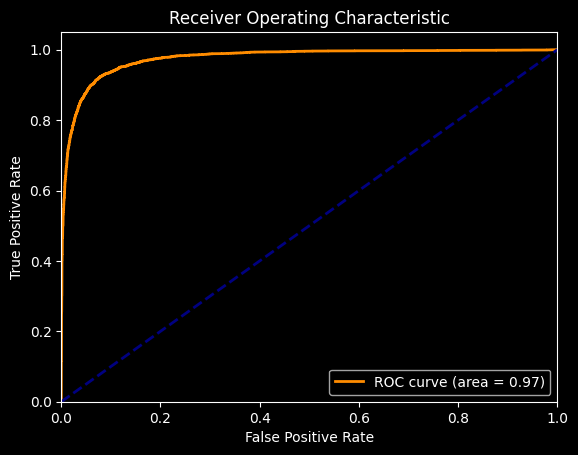

In [21]:
# Assuming 'predictions' from trainer.predict contains probabilities for each class
probabilities = predictions.predictions
# Extract probabilities for the positive class ('Positive (1)')
positive_probabilities = probabilities[:, 1]
# Create the ROC curve
fpr, tpr, thresholds = roc_curve(test_dataset['label'], positive_probabilities)
# Calculate the AUC
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

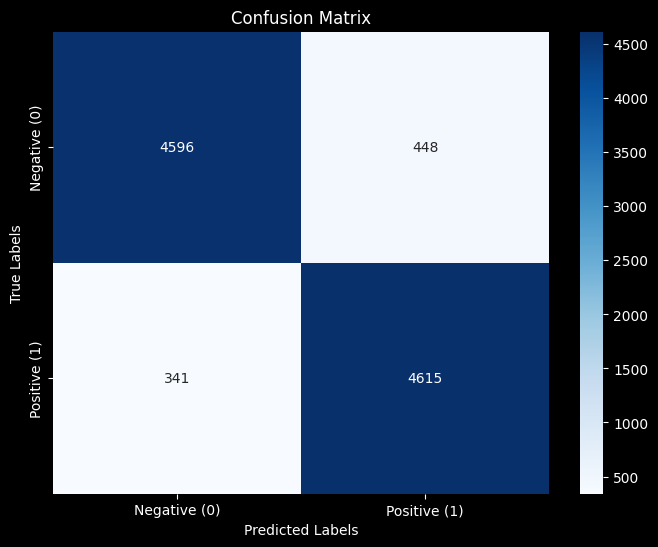

In [22]:
# Compute the confusion matrix
true_labels = test_dataset["labels"]
cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative (0)', 'Positive (1)'],
            yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# Extract TP, TN, FP, FN from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 4615
True Negatives (TN): 4596
False Positives (FP): 448
False Negatives (FN): 341


In [24]:
# Print the classification report
print("Classification Report :\n",classification_report(true_labels, predicted_labels, target_names=['Negative (0)', 'Positive (1)']))

Classification Report :
               precision    recall  f1-score   support

Negative (0)       0.93      0.91      0.92      5044
Positive (1)       0.91      0.93      0.92      4956

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



<a id="8"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Predictive for Test</p></b></h1>

In [25]:
# Load model directly
tokenizer = LongformerTokenizerFast.from_pretrained("ahmed792002/Finetuning_Longformer_IMDb_movie_reviews_Classification")
model = LongformerForSequenceClassification.from_pretrained("ahmed792002/Finetuning_Longformer_IMDb_movie_reviews_Classification")

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

In [26]:
def make_inference(text,label):
    # Set device to match model's device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move model to the correct device
    model.to(device)
    # Tokenize the input sentences
    inputs = tokenizer(text, return_tensors="pt",max_length=1024,truncation=True, padding="max_length")
    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}
    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    target_names=['Negative (0)', 'Positive (1)']
    print("Text : ",text)
    print("\n","*"*10,"\n")
    print("Actual Output : ",target_names[label])
    print("Output : ",target_names[predicted_class])

In [27]:
text , label = test_dataset["text"][1000],test_dataset["label"][1000]
make_inference(text,label)

Text :  want horrible interpretation macbeth answer filled archaic shakespearic english language st century australian setting film lives disappoint leave scratching head br br sophomoric action sequences plenty scenes female body displayed witches played actresses resemble school girls witches put soft porn display macbeth unremarkable display affection welcome stupidity depravity time br br wonder project green lighted much modern cheesy movies

 ********** 

Actual Output :  Negative (0)
Output :  Negative (0)


In [28]:
text , label = test_dataset["text"][200],test_dataset["label"][200]
make_inference(text,label)

Text :  unfortunately mate watched showing sky channel called zone horror basically shows crappy b movie horror films boring friday night decided laugh give one look apart atrocious acting awful plot dire effects shoddy camera work brain numbing ridiculousness ok lol seriousness quite laugh picking holes laughing goofy actors bit semi nudity perked movie bit unfortunately uggo got topless mate calls od bored one evening happens playing take chance might like

 ********** 

Actual Output :  Negative (0)
Output :  Negative (0)


In [29]:
text , label = test_dataset["text"][50],test_dataset["label"][50]
make_inference(text,label)

Text :  give reserve rating guy ritchie woody allen films even remember movie thing recall one gunshot scene actors drop ground roll side hallway something get back shooting like watching year olds broken legs trying perform stunts also characters driving truck engine noise radio recall would vanish entirely actors talking br br like others bought sandra bullock front cover sad bad

 ********** 

Actual Output :  Negative (0)
Output :  Negative (0)


In [30]:
text , label = test_dataset["text"][8800],test_dataset["label"][8800]
make_inference(text,label)

Text :  kurt russell whose career started kicked real elvis happened world fair probably never top performance king biopic helmed slash shock meister carpenter times feel watching elvis something snaps back reality perhaps memories hapless johnson elvis beauty queen performances excellent season hubley priscilla pat hingle colonel even shelley winters brings right level nerves hysteria rendering momma presley br br kurt dad bing playing elvis father vernon fine understated performance robert gray elvis buddy bodyguard red west br br must see rock n roll fans

 ********** 

Actual Output :  Positive (1)
Output :  Positive (1)


In [31]:
text , label = test_dataset["text"][20],test_dataset["label"][20]
make_inference(text,label)

Text :  rented movie low expectations pleasantly surprised movie extremely good stuff one would never guess low budget br br eighteen directed richard bell centers around year old named pip played superb paul anthony leaves home circumstances surrounding way older brother died overcome guilt event falls hard life runaway teen drugs alcohol th birthday father tracks pip gives tape left grandfather listen th birthday br br way whole film told two simultaneous stories unfolding time present life pip past life grandfather ww pip listens tape br br three outstanding performances movie ones paul anthony pip brenden fletcher playing jason young year ww soldier grandfather also role ww wounded medic macauley played mark hildreth putting fine performances br br couple concerns scenes sit well priest father chris played alan cumming gay broad daylight pick local street hustler whole neighborhood knows local store clerk named jeff sweetheart played attractive david beaszely wants loved unknown re

<center><span style="font-family:Palatino; font-size:22px;"><i>Like this? <span style="color:#DC143C;">Upvote and Comment!</span> </i>🌊 End</span> </center>